# Bouncing simulation
The equation of motion is given by 
$$m\frac{d^2y}{dt^2} = F_{EP} + F_{img} + F_{DEP} + F_{d}$$

where
$$f_{EP} = qE$$ and $$f_{DEP} = 2 \pi  R_{drop}^3 \epsilon_{air}  K  \epsilon_0  \nabla |E|^2$$

In this geometry

$$E = 2 \pi k \sigma \left(1 - \frac{z}{\sqrt{z^2 + R^2}}\right)$$
and
$$\nabla |E|^2 = 2 (2 \pi k \sigma)^2 R^2 \frac{z - \sqrt{R^2 + z^2}}{(R^2 + z^2)^2} $$


In [1]:
import numpy as np

#inputs
V = 300
d = 2.54/100
sigma =145*1.1/3*5.5E-8      # charge density
R = 2.54/200           # surface radius [m] 
q = 6*2.3*2E-11        # droplet net charge [C]
volume = 0.06 #0.065  # droplet volume [mL]
u0 = (15.3-1)/100          # droplet initial velocity [m/s]
puddleness = 3/2
m = 1000 * volume * 1E-6                          #droplet mass [kg]
R_drop = (3 * volume * 1E-6/(np.pi * 4))**(1/3.)  #droplet radius [m]
z0 = R_drop/puddleness

#physical constants
eta_0 = 8.85E-12       # vacuum permitivity 
k = 1/(4*np.pi*eta_0)  # Coulomb's constant
global k, eta_0

print('drop radius {:.2f} cm'.format(R_drop*100))
#print(np.sqrt(q*R*sigma/eta_0))
print('surface potential {:.2} '.format(V*eta_0/d))
print('surface charge density {:.2} C/m^2'.format(sigma))
print(q)

drop radius 0.24 cm
surface potential 1e-07 
surface charge density 2.9e-06 C/m^2
2.76e-10


Simulated fieldmeter reading 0.50 kV
Simulated fieldmeter reading 17.44 kV/m


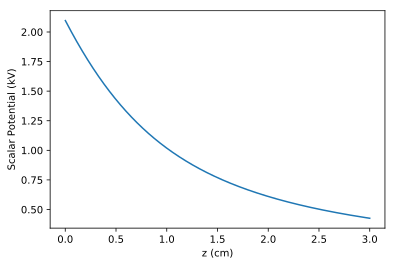

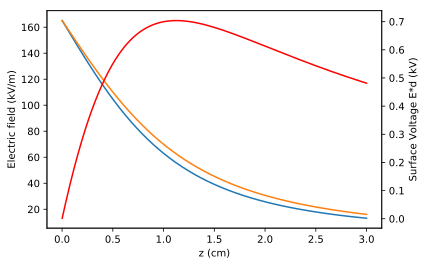

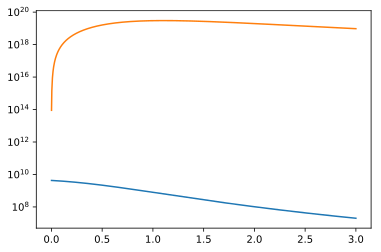

In [2]:
def electric_field(z, R=R, sigma=sigma):
    E = k * sigma * 2 * np.pi * (1 - z/np.sqrt(z**2. + R**2.))
    #E = 664/(2.54/100)
    del_E2 = 2 * (k * sigma * 2 * np.pi)**2. * R**2. * (z - np.sqrt(R**2. + z**2.))/(R**2. + z**2.)**2.
    V = k * sigma * 2 * np.pi * (np.sqrt(z**2. + R**2.) - z)
    E_sqr = 4*k*sigma*np.arctan(d**2/(2*z*np.sqrt(2*d**2 + 4*z**2)))
    del_E_sqr2 = 32* k**2 *((-2* d**2)/(2 *d**2 + 4 *z**2)**(3/2) - d**2/(2 *z**2 *np.sqrt(2 *d**2 + 4* z**2))\
                            *sigma**2 *np.arctan(d**2/(2 *z *np.sqrt(2* d**2 + 4* z**2))))\
    /(1 + d**4/(4* z**2 *(2 *d**2 + 4 *z**2)))
    return E, del_E2, V, E_sqr, del_E_sqr2

print('Simulated fieldmeter reading {:.2f} kV'.format(electric_field(2.54/100)[2]/1000))
print('Simulated fieldmeter reading {:.2f} kV/m'.format(electric_field(2.54/100)[0]/1000))

# Plot the results
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import pylab
%config InlineBackend.figure_formats=['svg']
%matplotlib inline
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('text', usetex=True)

zz = np.linspace(0.00001, 3./100, 1000)              
#zz = np.linspace(0, 4, 1000)
plt.plot(zz*100, electric_field(zz)[2]/1000)
plt.xlabel('z (cm)')
plt.ylabel('Scalar Potential (kV)')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(zz*100, electric_field(zz)[0]/1000, zz*100, electric_field(zz)[3]/1000)
ax2 = ax1.twinx()
ax2.plot(zz*100, np.multiply(electric_field(zz)[3],zz)/1000, 'r')
ax1.set_xlabel('z (cm)')
ax1.set_ylabel('Electric field (kV/m)')
ax2.set_ylabel('Surface Voltage E*d (kV)')
plt.show()

plt.semilogy(zz*100, np.abs(electric_field(zz)[1]/1000), zz*100, np.abs(electric_field(zz)[4]/1000))
plt.show()

This looks correct!

In [3]:
def force_ep(z, q=q):
    eta_a=3
    im = -1/(16*np.pi*1*eta_0)*(1-eta_a)/(1+eta_a)*q**2/z**2
    return q * electric_field(z)[3] + im

def force_dep(z, R_drop=R_drop):
    eta_air = 1.
    eta_water = 90.
    K = (eta_water - eta_air)/(eta_water + 2 * eta_air)
    return -2 * np.pi * R_drop**3. * eta_air * K * eta_0 * electric_field(z)[4]

def reynolds(v, R_drop=R_drop):
    nu = 15.11E-6
    D = R_drop * 2
    return D*np.abs(v)/nu

def drag(v, R_drop=R_drop):
    rho = 1.225
    Cd = 24/reynolds(v) + 5/np.sqrt(reynolds(v)) + 0.3
    return Cd*2*rho*np.pi*R_drop**2*v**2
    
print('DEP {}'.format(force_dep(R_drop/3)))
print('EP {}'.format(force_ep(R_drop/3)))

DEP 446.8983055519844
EP 0.00017363475612141145


In [4]:
# model data
def exp_data(x):
    v = -11.281*x**5 + 66.22*x**4 - 145.47*x**3 + 148.49*x**2 - 70.216*x + 15.301
    a = -11.281*5*x**4 + 66.22*4*x**3 - 145.47*3*x**2 + 148.49*2*x - 70.216
    y = 15.301*x - 35.108*x**2 + 49.4967*x**3 - 36.3675*x**4 + 13.244 *x**5 - 1.88017* x**6
    return v, a, y

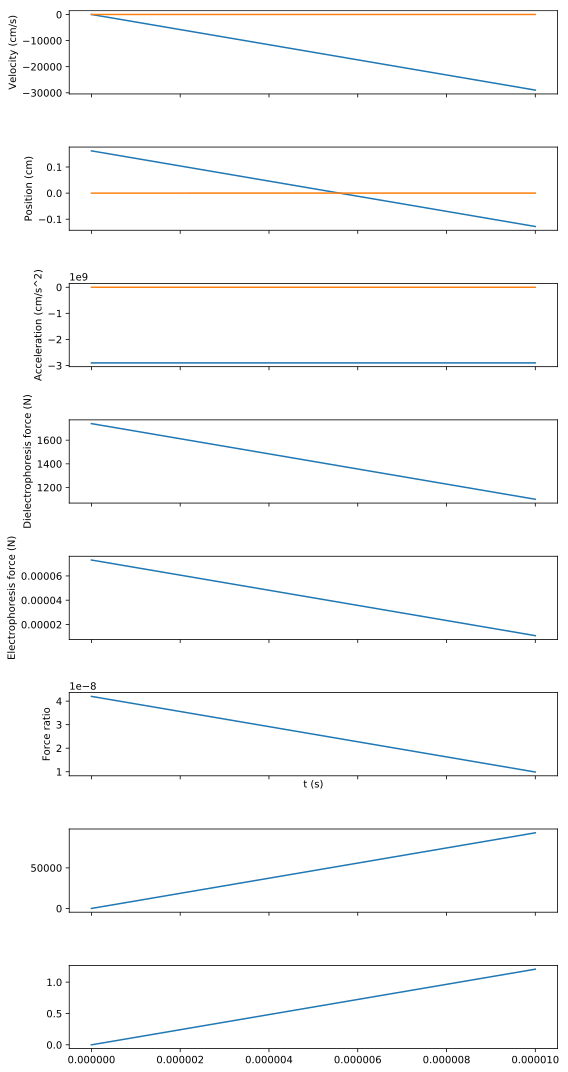

In [5]:
x = np.array([R_drop/puddleness]).tolist()
v = [u0]
t = [0]
EP = [force_ep(x[0])]
DEP = [force_dep(x[0])]
a = [(-EP[0] - DEP[0])/m]
re = [reynolds(v[0])]
drg = [drag(v[0])]

dt = 0.00001
    
while x[-1] >= R_drop/puddleness and t[-1] <= 1.6:
    a.append((-EP[-1] - DEP[-1] - drg[-1])/m)
    v.append(a[-1]*dt + v[-1])
    x.append(v[-1]*dt + x[-1])
    EP.append(force_ep(x[-1]))
    DEP.append(force_dep(x[-1]))
    re.append(reynolds(v[-1]))
    drg.append(drag(v[-1]))
    t.append(t[-1] + dt)

EP  = np.array(EP)
DEP = np.array(DEP)
a   = np.array(a)
v   = np.array(v)
x   = np.array(x)
t   = np.array(t)
re  = np.array(re)

# plotting
pylab.rcParams['figure.figsize'] = (8.0, 15.0)
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, sharex=True)
ax1.plot(t, v*100, t, exp_data(t)[0])
ax1.set_ylabel("Velocity (cm/s)")
ax2.plot(t, x*100, t, exp_data(t)[2])
ax2.set_ylabel("Position (cm)")
ax3.plot(t, a*100, t, exp_data(t)[1])
ax3.set_ylabel("Acceleration (cm/s^2)")
ax6.plot(t, EP/DEP)
ax6.set_ylabel("Force ratio")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.plot(t, DEP)
ax4.set_ylabel("Dielectrophoresis force (N)")
ax5.plot(t, EP)
ax5.set_ylabel("Electrophoresis force (N)")
ax7.plot(t, re)
ax8.plot(t, drg)
ax6.set_xlabel("t (s)")
f.tight_layout()
plt.show()

<function matplotlib.pyplot.show>

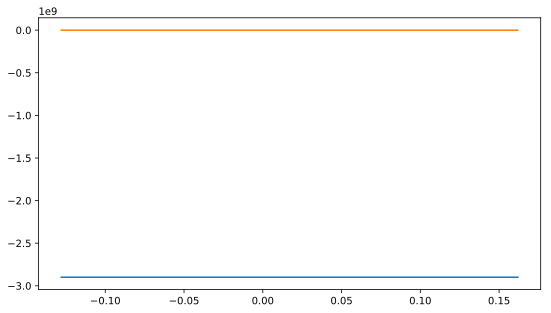

In [6]:
plt.figure(figsize=(9,5))
plt.plot(x*100, a*100, x*100, exp_data(t)[1])
plt.show

In [7]:
ratio = EP[0]/(DEP[0] + drg[0])
print(ratio)

4.19967991617e-08


In [8]:
import scipy.integrate as int

def f(y, t, params):
    z, u = y      # unpack current values of y
    m, R_drop, sigma, q = params # unpack parameters   
    derivs = [u, (-force_dep(z) - force_ep(z) - drag(u))/m] # list of dy/dt=f functions
    return derivs

# Initial values
z0 = z0    # initial displacement
u0 = u0     # initial velocity

# Bundle parameters for ODE solver
params = [m, R_drop, sigma, q]

# Bundle initial conditions for ODE solver
y0 = [z0, u0]

# Make time array for solution
tStop = 2.2
tInc = 0.0005
t_rk = np.arange(0., tStop, tInc)

# Call the ODE solver
psoln = int.odeint(f, y0, t_rk, args=(params,))

/home/erin/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


/home/erin/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1747: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


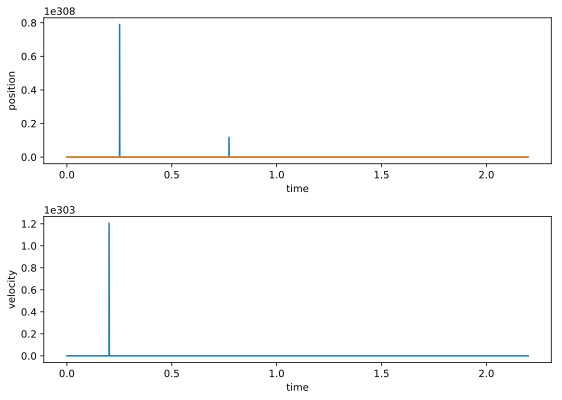

In [9]:
# Plot results
fig = plt.figure(1, figsize=(8,8))

# Plot theta as a function of time
ax1 = fig.add_subplot(311)
ax1.plot(t_rk, psoln[:,0]*100, t_rk, exp_data(t_rk)[2])
ax1.set_xlabel('time')
ax1.set_ylabel('position')

# Plot omega as a function of time
ax2 = fig.add_subplot(312)
ax2.plot(t_rk, psoln[:,1]*100)
ax2.set_xlabel('time')
ax2.set_ylabel('velocity')

plt.tight_layout()
plt.show()

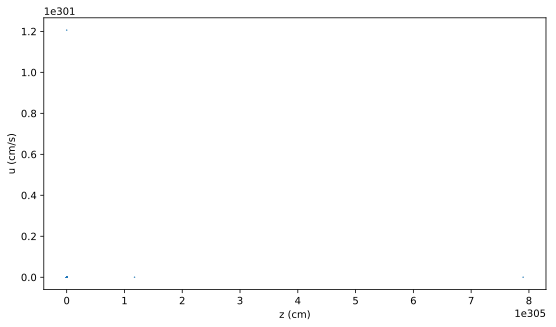

In [10]:
# Plot omega vs theta
plt.figure(figsize=(9,5))
plt.plot(psoln[:,0], psoln[:,1], '.', ms=1)
plt.xlabel('z (cm)')
plt.ylabel('u (cm/s)')
plt.show()

Need to get acceleration from psoln, make notes about integrator, methods...

In [11]:
from sympy import *
init_printing()

y, z, nu, a = symbols('y z nu a')
nu*integrate(z/((z**2 + y**2)*sqrt(z**2 + y**2 + a**2/4)), (y,0,a/2))

TypeError: 'NoneType' object is not subscriptable

In [ ]:
print(a)

Perhaps I need a substution of some kind.

In [ ]:
z = np.linspace(0.0001,10/100,1000)
a = d
k = 1/(4*np.pi*eta_0)
def E(z):
    return 4*k*sigma*np.arctan(a**2/(2*z*(2*a**2 + 4*z**2)**(1/2)))

#k, sigma, a, z, = symbols('k, sigma, a, z')
#pprint(4*k*sigma*atan(a**2/(2*z*(2*a**2 + 4*z**2)**(1/2))))
%matplotlib inline
plt.figure
plt.loglog(z, E(z)/(sigma/(2*np.pi*eta_0)))
#plt.autoscale(enable=True, axis='y', tight=True)
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()
